In [3]:
import os
import json
import re
import collections

In [4]:
data_path="/opt/ml/data/"
context_path= "wikipedia_documents.json"
with open(os.path.join(data_path, context_path), "r", encoding="utf-8") as f:
    wiki = json.load(f)

In [9]:
wiki_data = {}

for key in wiki.keys() :
    data = wiki[key]
    doc_id = data['document_id']
    text = data['text']
    
    wiki_data[doc_id] = text

In [10]:
print('Data Size : %d' %len(wiki_data))

Data Size : 60613


In [30]:
import sys
import logging
import os
import sys
import re

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from typing import List, Callable, NoReturn, NewType, Any
import dataclasses
from datasets import load_metric, load_from_disk, Dataset, DatasetDict

from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer
from transformers import (
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    TrainingArguments,
    set_seed,
)

In [13]:
sys.path.append('../')

In [14]:
from tokenizers import Tokenizer

from utils_qa import postprocess_qa_predictions, check_no_error
from trainer_qa import QuestionAnsweringTrainer
from retrieval import SparseRetrieval

from arguments import (
    ModelArguments,
    DataTrainingArguments,
)

In [24]:
model_args = ModelArguments

config = AutoConfig.from_pretrained(
    model_args.config_name 
    if model_args.config_name is not None
    else model_args.model_name_or_path,
)
print(config)

# -- Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_args.tokenizer_name
    if model_args.tokenizer_name is not None
    else model_args.model_name_or_path,
    use_fast=True,
)
 

/opt/conda/lib/python3.8/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}



## Preprocessing

In [26]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [31]:
unk_id = tokenizer.convert_tokens_to_ids('[UNK]')

unk_words = []
for i in tqdm(wiki_data.keys()) :
    text = wiki_data[i]
    sen_list = sent_tokenize(text)
    for sen in sen_list :
        word_list = word_tokenize(sen)
        for word in word_list :
            if unk_id in tokenizer.encode(word) :
                unk_words.append(word)
            

Token indices sequence length is longer than the specified maximum sequence length for this model (713 > 512). Running this sequence through the model will result in indexing errors


In [32]:
unk_word_set = list(set(unk_words))
print('Size of Words which make UNK Token : %d' %len(unk_word_set))

Size of Words which make UNK Token : 116862


In [33]:
unk_chars = []

for word in unk_word_set :
    for ch in word :
        if tokenizer.convert_tokens_to_ids(ch) == unk_id :
            unk_chars.append(ch)

unk_codes = [ord(ch) for ch in unk_chars if ord(ch) < 100000]

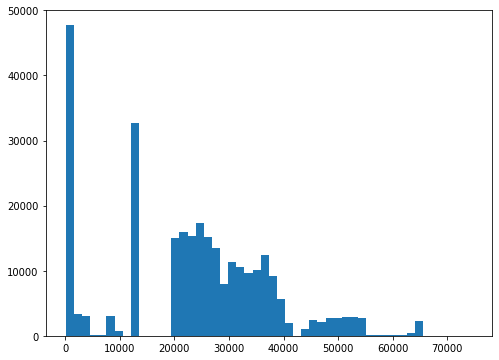

In [48]:
plt.figure(figsize = (8,6))
plt.hist(unk_codes, bins=50)
plt.show()

In [35]:
unk_char_counter = collections.Counter()
unk_char_counter.update(unk_chars)

In [42]:
unk_char_items = sorted(unk_char_counter.items(), key=lambda x : x[1], reverse=True)

In [50]:
unk_char_items

[('\\', 25476),
 ('。', 7377),
 ('李', 1698),
 ('、', 1574),
 ('–', 1551),
 ('為', 1125),
 ('ー', 1072),
 ('謂', 1022),
 ('等', 788),
 ('ン', 736),
 ('六', 709),
 ('何', 650),
 ('諸', 646),
 ('（', 638),
 ('い', 634),
 ('）', 609),
 ('к', 566),
 ('郡', 564),
 ('в', 559),
 ('縣', 540),
 ('樂', 533),
 ('á', 518),
 ('л', 508),
 ('α', 506),
 ('應', 499),
 ('種', 493),
 ('羅', 490),
 ('卷', 490),
 ('ス', 482),
 ('智', 476),
 ('イ', 475),
 ('識', 474),
 ('ā', 472),
 ('║', 467),
 ('觸', 465),
 ('云', 457),
 ('興', 455),
 ('ん', 454),
 ('阿', 447),
 ('隨', 441),
 ('忠', 440),
 ('里', 435),
 ('ル', 427),
 ('若', 421),
 ('根', 421),
 ('勝', 417),
 ('し', 416),
 ('令', 415),
 ('ο', 415),
 ('皇', 415),
 ('ا', 412),
 ('国', 412),
 ('永', 409),
 ('欲', 397),
 ('ラ', 393),
 ('因', 390),
 ('ト', 388),
 ('ü', 381),
 ('な', 379),
 ('と', 377),
 ('\uf537', 376),
 ('守', 376),
 ('か', 376),
 ('孝', 375),
 ('起', 370),
 ('松', 360),
 ('流', 359),
 ('順', 356),
 ('慶', 355),
 ('尹', 355),
 ('郎', 355),
 ('う', 348),
 ('る', 343),
 ('リ', 343),
 ('м', 340),
 ('ó', 340

## Document Length

In [153]:
wiki_data_len = []

for i in range(len(wiki_data)) :
    doc = wiki_data[i]
    doc_len = len(wiki_data[i])
    wiki_data_len.append(doc_len)

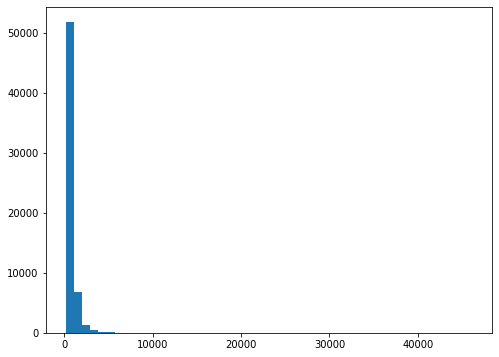

In [154]:
plt.figure(figsize = (8,6))
plt.hist(wiki_data_len, bins=50)
plt.show()

In [156]:
print('Max Size of Wiki Data : %d' %max(wiki_data_len))

Max Size of Wiki Data : 46099


In [157]:
wiki_data_len = [doc_len for doc_len in wiki_data_len if doc_len < 10000]

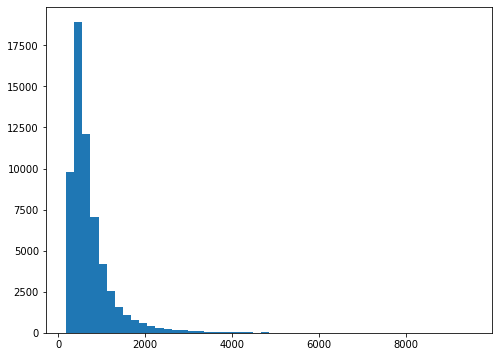

In [158]:
plt.figure(figsize = (8,6))
plt.hist(wiki_data_len, bins=50)
plt.show()

## Train Data

In [160]:
datasets = load_from_disk('/opt/ml/data/train_dataset')

In [161]:
datasets['train']

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 3952
})

In [163]:
train_doc_len = [len(doc) for doc in datasets['train']['context']]

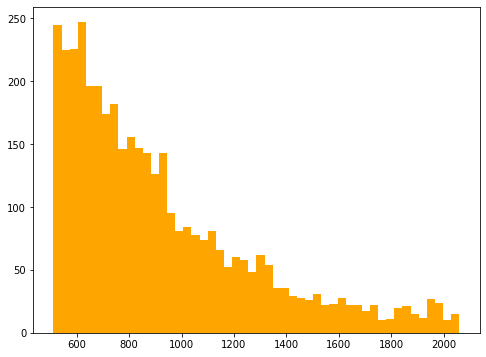

In [165]:
plt.figure(figsize = (8,6))
plt.hist(train_doc_len, color='orange', bins=50)
plt.show()

In [166]:
sep_case_txt = []

for i in range(len(wiki_data)) :
    doc = wiki_data[i]
    doc_len = len(wiki_data[i])

    if doc_len > 2000 :
        sep_case_txt.append(doc)

In [167]:
print('Size of text which length is over than 2000 : %d' %len(sep_case_txt))

Size of text which length is over than 2000 : 2102


In [171]:
import kss

[Korean Sentence Splitter]: Initializing Kss...


In [172]:
sep_case_sen_data = []

for i, txt in enumerate(tqdm(sep_case_txt)) :
    sen_list = kss.split_sentences(txt)
    sep_case_sen_data.append(sen_list)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 